In [1]:
%cd ..

/Users/sunilsaini/Desktop/Call_analytics/poc-call-analytics-data_retrieval-embeddings


/Users/sunilsaini/Desktop/Call_analytics/poc-call-analytics-data_retrieval-embeddings/embeddings_env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from datetime import datetime, timezone

import matplotlib.pyplot as plt
import pandas as pd
import pytz
import seaborn as sns

from src.settings import PATH_AIRCALL_PROCESSED

Matplotlib is building the font cache; this may take a moment.


# 2 - Exploratory Data Analysis - Aircall

This notebook aims to explore and understand the structure, distribution, and key characteristics of the call data retrieved from Aircall.

In [3]:
### Specify the following variables ###
INPUT_FILE = f"{PATH_AIRCALL_PROCESSED}/20250101_20250224_PS.csv" # Just edit the filename. Directory is handled by the environment variable
#######################################

## Load data

In [4]:
calls_df = pd.read_csv(INPUT_FILE, encoding="latin-1")

## Descriptive Statistics

### Overview & Summary

In [5]:
# Not all calls have a transcription, summary, topics, or sentiment. Replacing the PII artifact of that here with NA
calls_df.replace("Error: Document text is empty.", pd.NA, inplace=True)

# Converting the timestamp columns to datetime objects
for col in ["started_at", "answered_at", "ended_at"]:
    calls_df[col] = calls_df[col].apply(
        lambda x: (
            datetime.fromtimestamp(int(x), tz=timezone.utc).astimezone(
                pytz.timezone("Europe/Berlin")
            )
            if pd.notna(x)
            else pd.NA
        )
    )

calls_df["day_of_week"] = calls_df["started_at"].dt.day_name()
calls_df.day_of_week = pd.Categorical(
    calls_df.day_of_week,
    categories=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
    ordered=True,
)

for ci_feature in ["transcription", "summary", "topics"]:
    # Using OpenAI rule of thumb of 1 token per 4 characters: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
    calls_df[f"token_estimate_{ci_feature}"] = calls_df[ci_feature].apply(lambda x: len(x)/4 if pd.notna(x) else 0)

calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype                        
---  ------                        --------------  -----                        
 0   id                            2000 non-null   int64                        
 1   sid                           2000 non-null   object                       
 2   direction                     2000 non-null   object                       
 3   status                        2000 non-null   object                       
 4   missed_call_reason            0 non-null      float64                      
 5   started_at                    2000 non-null   datetime64[ns, Europe/Berlin]
 6   answered_at                   2000 non-null   datetime64[ns, Europe/Berlin]
 7   ended_at                      2000 non-null   datetime64[ns, Europe/Berlin]
 8   duration                      2000 non-null   int64                        
 9

What does the data look like?

In [6]:
calls_df.head()

,id,sid,direction,status,missed_call_reason,started_at,answered_at,ended_at,duration,recording,...,number_country,country_code_a2,transcription,summary,sentiment,topics,day_of_week,token_estimate_transcription,token_estimate_summary,token_estimate_topics
0,2604408571,CA574acd4348a8f1b23ad9ea292fe30592,inbound,done,NaN,2025-02-20 09:34:40+01:00,2025-02-20 09:34:53+01:00,2025-02-20 09:39:34+01:00,294,https://production-fra-555773567328-web-record...,...,NL,DE,AGENT_1:\nIch habe eine tollste Beratung von d...,Der Kunde erkundigt sich nach der Verfügbarkei...,NEUTRAL,medikamentenverfügbarkeit\nclomipramin 25 mg\n...,Thursday,599.50,85.00,22.50
1,2610199581,CAbfbe59dd31525a01efdb4186374a0a00,inbound,done,NaN,2025-02-22 14:40:24+01:00,2025-02-22 14:40:34+01:00,2025-02-22 14:43:03+01:00,159,https://production-fra-555773567328-web-record...,...,NL,DE,AGENT_1:\nDas ist meine Name. Guten Tag.\n\nCU...,Der Anruf drehte sich um eine Anfrage eines Ku...,NEUTRAL,unterschied contra 2/3\nproduktnummern\npackun...,Saturday,339.25,83.25,19.75
2,2543811905,CA1899c2a2e06871ab8f32bfc746fb4e4a,inbound,done,NaN,2025-01-25 13:56:07+01:00,2025-01-25 13:58:13+01:00,2025-01-25 14:01:10+01:00,303,https://production-fra-555773567328-web-record...,...,NL,DE,"AGENT_1:\nGuten Tag, von Massage Abteilung. Me...","Der Kunde, **************, erkundigt sich nach...",POSITIVE,laktosefreiheit des medikaments\nrezeptbestell...,Saturday,776.25,109.75,30.50
3,2520093703,CA208f21f137c6323aaa36a1fdca2e4e6f,inbound,done,NaN,2025-01-15 16:48:45+01:00,2025-01-15 16:50:22+01:00,2025-01-15 16:56:20+01:00,455,https://production-fra-555773567328-web-record...,...,NL,NaN,"AGENT_1:\nUnd als Beratung, Sie sprechen mit *...",<NA>,NaN,<NA>,Wednesday,1079.50,0.00,0.00
4,2532038872,CA8b4dfc606a57263af31c066406931a91,inbound,done,NaN,2025-01-21 11:28:40+01:00,2025-01-21 11:30:25+01:00,2025-01-21 11:32:05+01:00,205,https://production-fra-555773567328-web-record...,...,NL,DE,AGENT_1:\nAlso von ****************** mein Nam...,Ein Kunde erkundigt sich nach den verfügbaren ...,NEUTRAL,nitrolingual größen\nrezeptpflicht\nverfügbare...,Tuesday,282.75,42.00,21.25


## Call Volume

In [7]:
calls_df.pivot_table(
    values=["id", "recording", "transcription", "summary", "topics", "sentiment"],
    index=["number_name"],
    aggfunc={
        "id": "count",
        "recording": "count",
        "transcription": "count",
        "summary": "count",
        "topics": "count",
        "sentiment": "count",
    },
    observed=False,
)

,id,recording,sentiment,summary,topics,transcription
number_name,,,,,,
CS Experts DE,1,1,0,0,0,1
PS PB EAV IVR Kosmetik (M),7,7,2,2,2,7
PS PB EAV IVR NEM (M),27,27,15,15,15,27
PS PB EAV IVR OTC & Rest (M),76,76,29,29,29,76
PS PB EAV IVR RX (M),59,59,32,32,32,59
PS PB SAE DE IVR Kosmetik (M),106,106,69,69,69,105
PS PB SAE DE IVR NEM (M),361,361,256,256,256,361
PS PB SAE DE IVR OTC & Rest (M),767,767,523,524,524,759
PS PB SAE DE IVR RX (M),596,596,405,405,405,594


Note here that even though all calls have a recording, not all of them have a transcription, summary, sentiment, and topics.

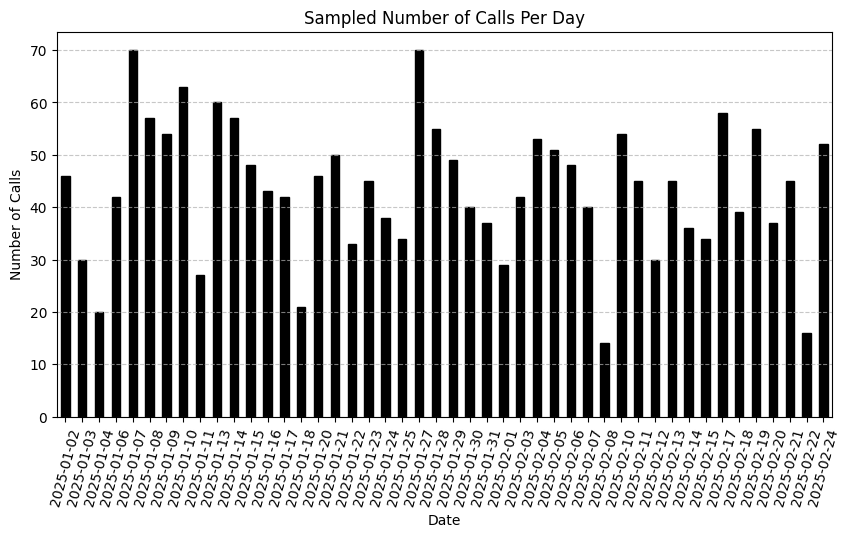

In [8]:
calls_per_day = calls_df.groupby(calls_df["started_at"].dt.date).size()

plt.figure(figsize=(10, 5))
calls_per_day.plot(kind='bar', color='black', edgecolor='black')

plt.xlabel("Date")
plt.ylabel("Number of Calls")
plt.title("Sampled Number of Calls Per Day")
plt.xticks(rotation=75)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

## Call Duration

In [9]:
calls_df.duration.describe()

count    2000.000000
mean      507.913500
std       350.437614
min        22.000000
25%       285.000000
50%       419.500000
75%       618.000000
max      3987.000000
Name: duration, dtype: float64

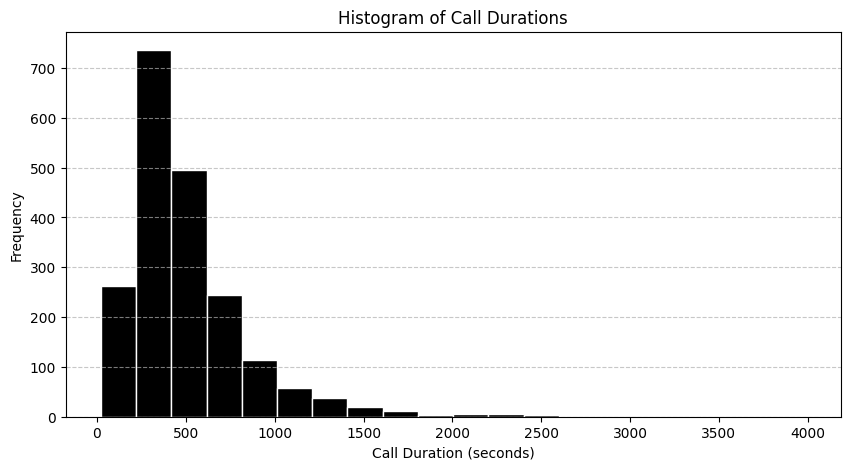

In [10]:
# Plot histogram of call durations
plt.figure(figsize=(10, 5))
plt.hist(calls_df['duration'], bins=20, color='black', edgecolor='white')

plt.xlabel("Call Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Histogram of Call Durations")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

/var/folders/qq/7j8twb6x4gs6hm5j39l3pp840000gn/T/ipykernel_5763/3990906056.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=calls_df["day_of_week"], y=calls_df["duration"], palette=["black"]*7, fill=False)


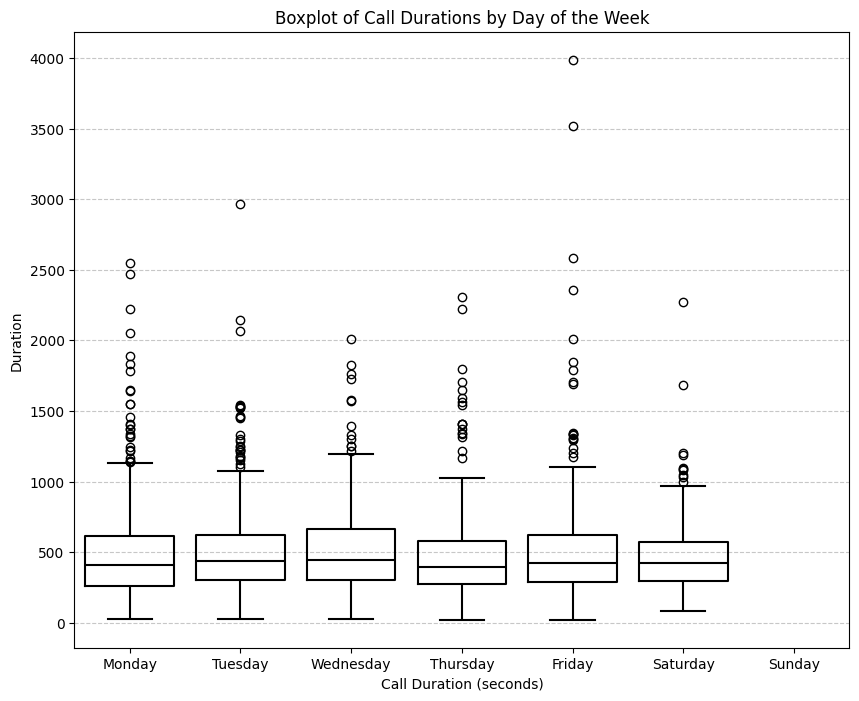

In [11]:
plt.figure(figsize=(10, 8))
sns.boxplot(x=calls_df["day_of_week"], y=calls_df["duration"], palette=["black"]*7, fill=False)

plt.xlabel("Call Duration (seconds)")
plt.ylabel("Duration")
plt.title("Boxplot of Call Durations by Day of the Week")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

## Conversational Intelligence

In [12]:
calls_df[calls_df["token_estimate_transcription"] != 0]["token_estimate_transcription"].describe()

count     1989.000000
mean      1419.624183
std       1193.892682
min          4.000000
25%        644.500000
50%       1093.250000
75%       1801.750000
max      10580.750000
Name: token_estimate_transcription, dtype: float64

In [13]:
calls_df[calls_df["token_estimate_transcription"] != 0]["token_estimate_transcription"].describe()

count     1989.000000
mean      1419.624183
std       1193.892682
min          4.000000
25%        644.500000
50%       1093.250000
75%       1801.750000
max      10580.750000
Name: token_estimate_transcription, dtype: float64

In [14]:
calls_df[calls_df["token_estimate_summary"] != 0]["token_estimate_summary"].describe()

count    1332.000000
mean      106.951577
std        25.276099
min        42.000000
25%        88.750000
50%       105.250000
75%       122.500000
max       196.250000
Name: token_estimate_summary, dtype: float64

In [15]:
calls_df[calls_df["token_estimate_topics"] != 0]["token_estimate_topics"].describe()

count    1332.000000
mean       27.225976
std         4.292123
min        15.250000
25%        24.250000
50%        27.000000
75%        30.000000
max        50.500000
Name: token_estimate_topics, dtype: float64